In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from datetime import timedelta, datetime

%matplotlib inline
from matplotlib import pyplot as plt

import xgcm

from parcels import FieldSet, ParticleSet, JITParticle, ParticleFile, plotTrajectoriesFile
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
# import tiles
tile_dir = '/home1/datahome/aponte/mit_equinox/parcels/test'
tl = pa.tiler(tile_dir=tile_dir)
tile = 2

In [2]:
# load llc grid
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]

# add U, V coordinates, seems not necessary
#grid = xgcm.Grid(grd)
#grd['YU'] = grid.interp(grd.YC, 'X', boundary='extend')
#grd['XV'] = grid.interp(grd.XC, 'Y', boundary='extend')
#grd = grd.set_coords(['XV', 'YU'])

#grd

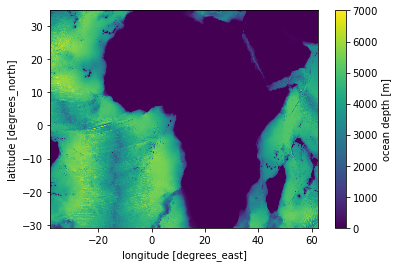

In [3]:
# tile grid data
grd = tl.tile(grd, tile=tile)

#plot
grd.Depth.plot(x='XC', y='YC')

In [4]:
ds = grd #.reset_coords(['Depth'])

ds['time'] = xr.DataArray([datetime(2020,1,1)+timedelta(days=n) for n in range(10)],  
                          dims='time').rename('time')
(_, ds['U']) = xr.broadcast(ds.time, ds.dxC)
(_, ds['V']) = xr.broadcast(ds.time, ds.dyC)
ds['U'] = ds.U*0. + 1
ds['V'] = ds.V*0. + 0

# i_g -> i, j->j_g
ds = pa.fuse_dimensions(ds)

In [9]:
# check grid layout: only when u and v points are added
#_ds = ds.isel(i=slice(3), j=slice(3))
#plt.plot(_ds.XC, _ds.YC, 'o', color='k', ms=10)
#plt.plot(_ds.XG, _ds.YU, '>', color='orange', ms=10)
#plt.plot(_ds.XV, _ds.YG, '^', color='cadetblue', ms=10)

In [6]:
variables = {'U': 'U', 
             'V': 'V',
             'waterdepth': 'Depth',
            }

# I thought originally, we need to provide u and v grids
#dims = {'U': {'lon': 'XG', 'lat': 'YU', 'time':'time'},
#        'V': {'lon': 'XV', 'lat': 'YG', 'time':'time'},
#        'depth': {'lon': 'XC', 'lat': 'YC'},
#       }
# is seems however that only central points are needed
dims = {'U': {'lon': 'XC', 'lat': 'YC', 'time':'time'},
        'V': {'lon': 'XC', 'lat': 'YC', 'time':'time'},
        'waterdepth': {'lon': 'XC', 'lat': 'YC'},
       }

fieldset = FieldSet.from_xarray_dataset(ds, 
                                        variables=variables,
                                        dimensions=dims,
                                        interp_method='cgrid_velocity',
                                       )

In [7]:
# Define a ParticleSet

# start from a reference position
i0, j0 = 500, 2000
lon0 = float(grd.XC.isel(i=i0, j=j0))
lat0 = float(grd.YC.isel(i=i0, j=j0))
print('lon0 = {:.2f}, lat0 = {:.2f}'.format(lon0, lat0))

xv, yv = np.meshgrid(lon0+np.arange(0, 20, 10), lat0+np.arange(0, 20, 1))
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, 
                   lon=xv.flatten(), lat=yv.flatten())

# Make sure to remove the particles that start on land
def DeleteParticle(particle, fieldset, time):
    particle.delete()

def RemoveOnLand(particle, fieldset, time):
    u, v = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    # not working below
    #water_depth = fieldset.waterdepth[particle.depth, particle.lat, particle.lon]
    #if math.fabs(particle.depth) < 500:
    if math.fabs(u) < 1e-12:
        particle.delete()

pset.execute(RemoveOnLand, dt=0, recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

lon0 = -27.57, lat0 = 5.99


INFO: Compiled JITParticleRemoveOnLand ==> /dev/shm/pbs.9973618.datarmor0/parcels-55081/652f48b260152b69e6cd950b8fc306f1_0.so


In [8]:
# Now run the remaining ParticleSet (using less accurate Euler Forward for speedup)
# alternative is AdvectionRK4
pset.execute(AdvectionEE, runtime=timedelta(days=1), dt=timedelta(hours=1),
             output_file=pset.ParticleFile('llc_particles.nc',
                                           outputdt=timedelta(hours=4)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
#plotTrajectoriesFile('llc_particles.nc') # need to download data for cartopy

INFO: Compiled JITParticleAdvectionEE ==> /dev/shm/pbs.9973618.datarmor0/parcels-55081/0e552e7c6d35360ed50bd930c94625d9_0.so


In [9]:
out = xr.open_dataset('llc_particles.nc', cache=False)
out

<xarray.Dataset>
Dimensions:     (obs: 7, traj: 40)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

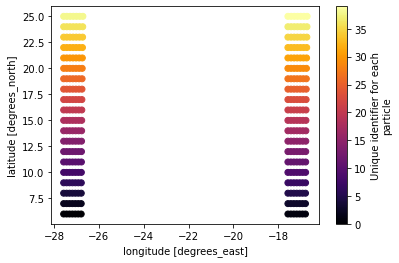

In [10]:
out.plot.scatter(x='lon', y='lat', hue='trajectory', cmap='inferno')

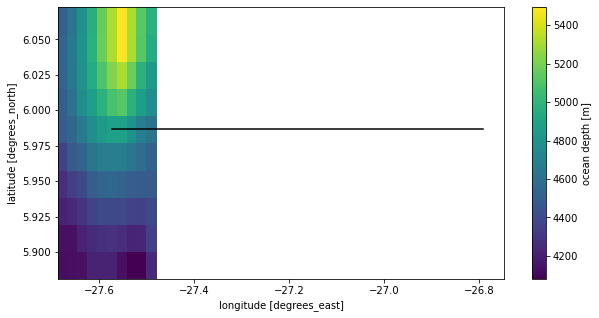

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

dij = 5
_grd = grd.isel(i=slice(i0-dij, i0+dij), j=slice(j0-dij, j0+dij))
_grd.Depth.plot(ax=ax, x='XC', y='YC')

_out = out.isel(traj=0)
ax.plot(_out.lon,_out.lat,'k')

---

## with many more points

In [12]:
_grd = grd.isel(i=slice(10,-10,40), j=slice(10,-10,40))
xv, yv = _grd.XC.values, _grd.YC.values

In [13]:
#
# Define a ParticleSet
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, 
                   lon=xv.flatten(), lat=yv.flatten())

# Make sure to remove the particles that start on land
def DeleteParticle(particle, fieldset, time):
    particle.delete()

def RemoveOnLand(particle, fieldset, time):
    u, v = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    #if math.fabs(particle.water_depth) < 500:
    if math.fabs(u) < 1e-12:
        particle.delete()

pset.execute(RemoveOnLand, dt=0, recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled JITParticleRemoveOnLand ==> /dev/shm/pbs.9973618.datarmor0/parcels-55081/15b9983e7e32396509dbf18300beee9d_0.so


In [14]:
# Now run the remaining ParticleSet (using less accurate Euler Forward for speedup)
# alternative is AdvectionRK4
pset.execute(AdvectionEE, runtime=timedelta(days=1), dt=timedelta(hours=1),
             output_file=pset.ParticleFile('llc_particles_large.nc',
                                           outputdt=timedelta(hours=4)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
#plotTrajectoriesFile('llc_particles.nc') # need to download data for cartopy

INFO: Compiled JITParticleAdvectionEE ==> /dev/shm/pbs.9973618.datarmor0/parcels-55081/10ab6c1692fcc991a6e3aa6108c24666_0.so


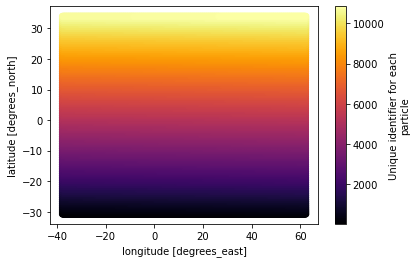

In [15]:
out = xr.open_dataset('llc_particles_large.nc', cache=False)
out.plot.scatter(x='lon', y='lat', hue='trajectory', cmap='inferno')

---
## with true flow


In [44]:
T = 10 # in days
# may crash fieldset creation, decrease tile size if necessary
# goes through with 10 days and 4x4 tiles

ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
ds = ds.isel(time=slice(0, T*24, None))
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])

ds = tl.tile(ds, tile=tile)

# i_g -> i, j->j_g
ds = pa.fuse_dimensions(ds)

# rechunk
ds = ds.chunk({'i':500, 'j':500})

In [45]:
variables = {'U': 'SSU',
             'V': 'SSV',
             'SST': 'SST',
             'waterdepth': 'Depth',
            }

dims = {'U': {'lon': 'XC', 'lat': 'YC', 'time': 'time'},
        'V': {'lon': 'XC', 'lat': 'YC', 'time': 'time'},
        'SST': {'lon': 'XC', 'lat': 'YC', 'time': 'time'},
        'waterdepth': {'lon': 'XC', 'lat': 'YC'},
       }

fieldset = FieldSet.from_xarray_dataset(ds, 
                                        variables=variables,
                                        dimensions=dims,
                                        interp_method='cgrid_velocity',
                                       )

In [46]:
_grd = grd.isel(i=slice(10,-10,40), j=slice(10, -10, 10))
xv, yv = _grd.XC.values, _grd.YC.values

#
# Define a ParticleSet
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, 
                   lon=xv.flatten(), lat=yv.flatten())

# Make sure to remove the particles that start on land
def DeleteParticle(particle, fieldset, time):
    particle.delete()

def RemoveOnLand(particle, fieldset, time):
    u, v = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    #if math.fabs(particle.water_depth) < 500:
    if math.fabs(u) < 1e-12:
        particle.delete()

pset.execute(RemoveOnLand, dt=0, recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled JITParticleRemoveOnLand ==> /dev/shm/pbs.9973770.datarmor0/parcels-55081/5afb635a01b7f54a216ccacd36b0e909_0.so


In [ ]:
# Now run the remaining ParticleSet (using less accurate Euler Forward for speedup)
# we will have to use AdvectionRK4 eventually
pset.execute(AdvectionEE, runtime=timedelta(days=T), dt=timedelta(hours=1),
             output_file=pset.ParticleFile('llc_uv.nc',
                                           outputdt=timedelta(hours=1)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
#plotTrajectoriesFile('llc_particles.nc') # need to download data for cartopy

INFO: Compiled JITParticleAdvectionEE ==> /dev/shm/pbs.9973770.datarmor0/parcels-55081/8fb88314ba5bd9283c502e0cee8927f3_0.so
INFO: Temporary output files are stored in out-ZOFWNEBN.
INFO: You can use "parcels_convert_npydir_to_netcdf out-ZOFWNEBN" to convert these to a NetCDF file during the run.
 20% (180000.0 of 864000.0) |##          | Elapsed Time: 0:27:45 ETA:   2:09:20

In [36]:
out = xr.open_dataset('llc_uv.nc').set_coords(['time'])
out = out.assign_coords(hours=(out.time - out.time[0,0].values)/pd.Timedelta('1h'))
out

<xarray.Dataset>
Dimensions:     (obs: 25, traj: 6036)
Coordinates:
    time        (traj, obs) datetime64[ns] 2011-11-15 ... 2011-11-16
    hours       (traj, obs) float64 0.0 1.0 2.0 3.0 4.0 ... 21.0 22.0 23.0 24.0
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

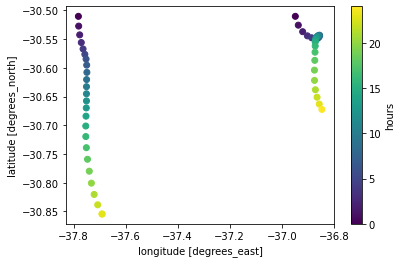

In [40]:
out.isel(traj=[0,1]).plot.scatter(x='lon', y='lat', hue='hours')

---
## xarray bug?

In [43]:
ds = xr.DataArray(np.arange(10), name='x').to_dataset()
ds.to_netcdf('test.nc', mode='w')
#ds_out = xr.open_dataset('test.nc')
#print(ds_out)

In [44]:
ds = xr.DataArray(np.arange(20), name='x').to_dataset()
ds.to_netcdf('test.nc', mode='w')
ds_out = xr.open_dataset('test.nc')
print(ds_out)

<xarray.Dataset>
Dimensions:  (dim_0: 10)
Dimensions without coordinates: dim_0
Data variables:
    x        (dim_0) int64 ...


In [41]:
import netCDF4 as nc
d = nc.Dataset('test.nc')
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(20)
    variables(dimensions): int64 x(dim_0)
    groups: 

In [45]:
#xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
python-bits: 64
OS: Linux
OS-release: 3.12.53-60.30-default
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8
libhdf5: 1.10.5
libnetcdf: 4.7.4

xarray: 0.15.1
pandas: 1.0.3
numpy: 1.18.1
scipy: 1.4.1
netCDF4: 1.5.3
pydap: None
h5netcdf: None
h5py: None
Nio: None
zarr: 2.4.0
cftime: 1.1.1.2
nc_time_axis: None
PseudoNetCDF: None
rasterio: None
cfgrib: None
iris: None
bottleneck: None
dask: 2.13.0
distributed: 2.13.0
matplotlib: 3.3.0
cartopy: 0.17.0
seaborn: 0.10.0
numbagg: None
setuptools: 46.1.3.post20200325
pip: 20.0.2
conda: None
pytest: None
IPython: 7.13.0
sphinx: None
